# GLIMPSE CREATOR 

This notebook takes a cell_ID, or series of cell_IDs and crops a 'glimpse' of the cell; a series of images lasting the duration of the cells existence that are focused on the cell and it's immediate neighbourhood.

Author: `Nathan J. Day`

In [56]:
import btrack
import matplotlib.pyplot as plt
import os
from skimage.io import imread, imsave, imshow
from tqdm import tqdm
import numpy as np
from pathlib import Path
from natsort import natsorted
import warnings
warnings.filterwarnings('ignore') ###bc imsave throws up low contrast warnings

# Establish glimpse params

In [23]:
expt_root_folder = '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/'

In [38]:
expt = 'MK0000'
pos = 'Pos5'

In [14]:
channels = ['003'] ### bf 000 gfp 001 rfp 002 irfp 003

focal_time_range = (0, 800) ### this particular expt stays in focus in this time range

# Load experiment tracking file

In [39]:
tracks_path = os.path.join(expt_root_folder,'{}/{}/gfp_tracks.h5'.format(expt, pos))

In [40]:
with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_1") as hdf:
    wt_tracks = hdf.tracks

[INFO][2021/05/21 01:54:21 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/gfp_tracks.h5...
[INFO][2021/05/21 01:54:21 PM] Loading tracks/obj_type_1
[INFO][2021/05/21 01:54:22 PM] Loading objects/obj_type_1 (176034, 5) (176034 filtered: None)
[INFO][2021/05/21 01:54:24 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/gfp_tracks.h5


(array([3.423e+03, 4.380e+02, 7.800e+01, 1.700e+01, 5.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00]),
 array([1.000e+00, 1.023e+02, 2.036e+02, 3.049e+02, 4.062e+02, 5.075e+02,
        6.088e+02, 7.101e+02, 8.114e+02, 9.127e+02, 1.014e+03]),
 <BarContainer object of 10 artists>)

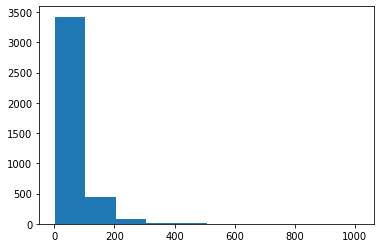

In [41]:
len_tracks = [len(track) for track in wt_tracks]
plt.hist(len_tracks)

In [42]:
### filter tracks that should contain a full cell cycle in (1 timepoint/frame = 4min, cc time approx 200 frames based on quick look)
long_tracks = [track for track in wt_tracks if len(track) > 200]

In [43]:
### filter tracks that spend a lot of time out of focus
tracks = [track for track in long_tracks if track.t[-1] < focal_time_range[1]]

In [44]:
len(tracks)

48

# Load image data

In [45]:
image_folder = os.path.join(expt_root_folder,expt, pos, pos+'_stacks')

# Make glimpse

In [50]:
output_dir = '/home/nathan/data/kraken/pcna/glimpses/{}/{}'.format(expt, pos)

for channel in channels:
    ### load images
    print('Loading image channel', channel)
    images = imread(os.path.join(image_folder, 'channel{}.tif'.format(channel)))
    print('Image loaded')
    ### create output directory
    output_ch_dir = os.path.join(output_dir, 'channel'+channel)
    Path(output_ch_dir).mkdir(parents=True, exist_ok=True)
    #os.mkdir(output_ch_dir) if os.path.exists(output_ch_dir) == False else print(output_ch_dir, 'already exists')
    
    for cell in tqdm(tracks):
        try:
            ### get length of track/glimpse 
            length = range(cell.t[0], cell.t[-1])
            ### get the xy coords of track/glimpse 
            y, x = cell.x, cell.y #### WHY IS THE COORDINATES TRANSPOSED???? 

            ### iterate over all frames cropping
            for j, i in enumerate(length): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
                ### obtain correct frame
                image = images[i]
                ### obtain coordinates of bounding box of glimpse (centered on cell)
                x1, x2, y1, y2 = x[j], x[j]+200, y[j], y[j]+200 #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
                ### pad image incase cell goes off FOV
                image = np.pad(image, 100, 'constant', constant_values = 0) 
                ## glimpse creation by cropping original image
                glimpse = image[int(x1): int(x2), int(y1): int(y2)]
                ### fraction of track this frame is at
                age = round(i/cell.t[-1],3) 
                fn = 'cell_ID_' + str(cell.ID) + '_channel' + channel + '_t{}_age{}.tif'.format(i, age)
                ### glimpse output
                imsave(os.path.join(output_ch_dir, fn), glimpse) 
            print('cell ID',cell.ID, 'glimpse saved')
            
        except:
            print(cell.ID, 'failed to produce glimpse')


Loading image channel 003


  0%|          | 0/48 [00:00<?, ?it/s]

Image loaded


  2%|▏         | 1/48 [00:00<00:46,  1.01it/s]

cell ID 34 glimpse saved


  4%|▍         | 2/48 [00:01<00:28,  1.62it/s]

cell ID 81 glimpse saved


  6%|▋         | 3/48 [00:01<00:27,  1.62it/s]

cell ID 85 glimpse saved


  8%|▊         | 4/48 [00:02<00:24,  1.79it/s]

cell ID 273 glimpse saved


 10%|█         | 5/48 [00:02<00:20,  2.12it/s]

cell ID 393 glimpse saved


 12%|█▎        | 6/48 [00:03<00:17,  2.42it/s]

cell ID 496 glimpse saved


 15%|█▍        | 7/48 [00:03<00:14,  2.78it/s]

cell ID 499 glimpse saved


 17%|█▋        | 8/48 [00:03<00:15,  2.57it/s]

cell ID 506 glimpse saved


 19%|█▉        | 9/48 [00:04<00:14,  2.74it/s]

cell ID 541 glimpse saved


 21%|██        | 10/48 [00:04<00:14,  2.70it/s]

cell ID 563 glimpse saved


 23%|██▎       | 11/48 [00:04<00:12,  2.97it/s]

cell ID 569 glimpse saved


 25%|██▌       | 12/48 [00:05<00:12,  2.91it/s]

cell ID 605 glimpse saved


 27%|██▋       | 13/48 [00:05<00:12,  2.75it/s]

cell ID 642 glimpse saved


 29%|██▉       | 14/48 [00:05<00:11,  3.05it/s]

cell ID 674 glimpse saved


 31%|███▏      | 15/48 [00:06<00:10,  3.00it/s]

cell ID 712 glimpse saved


 33%|███▎      | 16/48 [00:06<00:10,  2.98it/s]

cell ID 721 glimpse saved


 35%|███▌      | 17/48 [00:06<00:09,  3.11it/s]

cell ID 723 glimpse saved


 38%|███▊      | 18/48 [00:07<00:11,  2.55it/s]

cell ID 745 glimpse saved


 40%|███▉      | 19/48 [00:07<00:12,  2.34it/s]

cell ID 746 glimpse saved


 42%|████▏     | 20/48 [00:08<00:10,  2.64it/s]

cell ID 760 glimpse saved


 44%|████▍     | 21/48 [00:08<00:09,  2.89it/s]

cell ID 783 glimpse saved


 46%|████▌     | 22/48 [00:08<00:09,  2.70it/s]

cell ID 789 glimpse saved


 48%|████▊     | 23/48 [00:09<00:09,  2.75it/s]

cell ID 794 glimpse saved


 50%|█████     | 24/48 [00:09<00:08,  3.00it/s]

cell ID 797 glimpse saved


 52%|█████▏    | 25/48 [00:09<00:07,  3.13it/s]

cell ID 804 glimpse saved


 54%|█████▍    | 26/48 [00:09<00:07,  3.12it/s]

cell ID 807 glimpse saved


 56%|█████▋    | 27/48 [00:10<00:07,  2.82it/s]

cell ID 774 glimpse saved


 58%|█████▊    | 28/48 [00:10<00:08,  2.40it/s]

cell ID 777 glimpse saved


 60%|██████    | 29/48 [00:11<00:07,  2.64it/s]

cell ID 780 glimpse saved


 62%|██████▎   | 30/48 [00:11<00:06,  2.64it/s]

cell ID 810 glimpse saved


 65%|██████▍   | 31/48 [00:11<00:06,  2.75it/s]

cell ID 851 glimpse saved


 67%|██████▋   | 32/48 [00:12<00:05,  2.98it/s]

cell ID 855 glimpse saved


 69%|██████▉   | 33/48 [00:12<00:06,  2.49it/s]

cell ID 871 glimpse saved


 71%|███████   | 34/48 [00:13<00:05,  2.79it/s]

cell ID 885 glimpse saved


 73%|███████▎  | 35/48 [00:13<00:04,  2.95it/s]

cell ID 904 glimpse saved


 75%|███████▌  | 36/48 [00:13<00:04,  2.95it/s]

cell ID 913 glimpse saved


 77%|███████▋  | 37/48 [00:14<00:03,  2.76it/s]

cell ID 915 glimpse saved


 79%|███████▉  | 38/48 [00:14<00:03,  2.87it/s]

cell ID 916 glimpse saved


 81%|████████▏ | 39/48 [00:14<00:02,  3.01it/s]

cell ID 956 glimpse saved


 83%|████████▎ | 40/48 [00:15<00:02,  2.84it/s]

cell ID 974 glimpse saved


 85%|████████▌ | 41/48 [00:15<00:02,  3.05it/s]

cell ID 982 glimpse saved


 88%|████████▊ | 42/48 [00:15<00:01,  3.16it/s]

cell ID 994 glimpse saved


 90%|████████▉ | 43/48 [00:15<00:01,  3.16it/s]

cell ID 1001 glimpse saved


 92%|█████████▏| 44/48 [00:16<00:01,  2.94it/s]

cell ID 1024 glimpse saved


 94%|█████████▍| 45/48 [00:16<00:00,  3.07it/s]

cell ID 1031 glimpse saved


 96%|█████████▌| 46/48 [00:16<00:00,  3.27it/s]

cell ID 1041 glimpse saved


 98%|█████████▊| 47/48 [00:17<00:00,  3.44it/s]

cell ID 1046 glimpse saved


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]

cell ID 1088 glimpse saved


# Iterate over many positions

In [23]:
expt_root_folder = '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/'

In [58]:
expt = 'MK0000'
pos_list = natsorted([pos for pos in os.listdir(os.path.join(expt_root_folder, expt)) if 'Pos' in pos])

In [14]:
channels = ['003'] ### bf 000 gfp 001 rfp 002 irfp 003

focal_time_range = (0, 800) ### this particular expt stays in focus in this time range

# Load experiment tracking file

In [59]:
for pos in pos_list:
    print('starting', pos)
    tracks_path = os.path.join(expt_root_folder,'{}/{}/gfp_tracks.h5'.format(expt, pos))

    with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_1") as hdf:
        wt_tracks = hdf.tracks

    ### filter tracks that should contain a full cell cycle in (1 timepoint/frame = 4min, cc time approx 200 frames based on quick look)
    long_tracks = [track for track in wt_tracks if len(track) > 200]

    ### filter tracks that spend a lot of time out of focus
    tracks = [track for track in long_tracks if track.t[-1] < focal_time_range[1]]

    ### show number of filtered tracks
    print('number of glimpses to be generated:', len(tracks))

    ### find images and set output
    image_folder = os.path.join(expt_root_folder,expt, pos, pos+'_stacks')
    output_dir = '/home/nathan/data/kraken/pcna/glimpses/{}/{}'.format(expt, pos)

    for channel in channels:
        ### load images
        print('Loading image channel', channel)
        images = imread(os.path.join(image_folder, 'channel{}.tif'.format(channel)))
        print('Image loaded')
        ### create output directory
        output_ch_dir = os.path.join(output_dir, 'channel'+channel)
        Path(output_ch_dir).mkdir(parents=True, exist_ok=True)
        #os.mkdir(output_ch_dir) if os.path.exists(output_ch_dir) == False else print(output_ch_dir, 'already exists')

        for cell in tqdm(tracks):
            try:
                ### get length of track/glimpse 
                length = range(cell.t[0], cell.t[-1])
                ### get the xy coords of track/glimpse 
                y, x = cell.x, cell.y #### WHY IS THE COORDINATES TRANSPOSED???? 

                ### iterate over all frames cropping
                for j, i in enumerate(length): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
                    ### obtain correct frame
                    image = images[i]
                    ### obtain coordinates of bounding box of glimpse (centered on cell)
                    x1, x2, y1, y2 = x[j], x[j]+200, y[j], y[j]+200 #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
                    ### pad image incase cell goes off FOV
                    image = np.pad(image, 100, 'constant', constant_values = 0) 
                    ## glimpse creation by cropping original image
                    glimpse = image[int(x1): int(x2), int(y1): int(y2)]
                    ### fraction of track this frame is at
                    age = round(i/cell.t[-1],3) 
                    fn = 'cell_ID_' + str(cell.ID) + '_channel' + channel + '_t{}_age{}.tif'.format(i, age)
                    ### glimpse output
                    imsave(os.path.join(output_ch_dir, fn), glimpse) 
                print('cell ID',cell.ID, 'glimpse saved')

            except:
                print(cell.ID, 'failed to produce glimpse')


[INFO][2021/05/21 02:28:28 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks.h5...


starting Pos0


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# old method (needs a rewrite)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re
from scipy import ndimage
from skimage.io import imshow, imsave, imread #used to be from skimage import io
from sklearn import preprocessing
from matplotlib import animation
from natsort import natsorted
from pathlib import Path
#from skimage.external import tifffile
import tifffile
from btrack.dataio import HDF5FileHandler
import glob
from tensorflow.python.keras.models import Model, load_model
import json
import zipfile
import scipy
from scipy.spatial import KDTree
from skimage.transform import resize
from multiprocessing import Pool
from skimage.external import tifffile
import warnings
warnings.filterwarnings('ignore')

### Tiff virtual stack functions

In [ ]:
class VirtualTiffStack:
    def __init__(self, folder, channel_name):
        self.folder = folder 
        self.channel_name = channel_name
        # find the files and store them
        self.files = natsorted([file for file in os.listdir(os.path.join(self.folder, self.channel_name)) if file.endswith('.tif')])
        self.glimpse = [] ### would this work like this?????
    def __getitem__(self, idx):
        return tifffile.imread(os.path.join(self.folder, self.channel_name, self.files[idx]))
    def __len__(self):
        return len(self.files) ### what this do?

def str_convert(string): 
    li = list(string.split(", ")) 
    return li 

### Directory definitions

In [ ]:
mask_version = 'cellpose_nuclear_3'
#mask_version = 'cellpose_nuclear'
path = '/home/nathan/data/SHARC/fucci/fucci1_171201/'
path = '/home/nathan/data/kraken/fucci/2017_10_18/pos16'
gfp_stack = VirtualTiffStack(path, channel_name = 'gfp')
rfp_stack = VirtualTiffStack(path, channel_name = 'rfp')
channels = ['gfp', 'rfp']#, 'phase']
glimpses_folder = os.path.join(path,'glimpses')
Path(glimpses_folder).mkdir(parents=True, exist_ok=True) ## create glimpse folder
if 'phase' in channels: ## this just adds a phase channel for sharc data
    phase_stack = VirtualTiffStack(path, channel_name = 'phase')

### Load tracking data

In [ ]:
tracks_file = path+'/tracks/'+ mask_version + '.h5' ### should it be hdf5?
with HDF5FileHandler(tracks_file) as h:
    tracks = h.tracks[0] ### only loading 'WT' cells at the moment, hence h.tracks[0]
track_IDs = natsorted([track.ID for track in tracks]) #if len(track) > 400]) does this criterion mess with trackID indexing?
#print(track_IDs) ### CAN PUT CRITERION HERE ### for finding tracks of only certain length etc

In [ ]:
for i, j in enumerate(tracks):
    print(i, tracks[i].ID, "ID length is", len(tracks[i]))

# Glimpse rgb composite creation

In [ ]:
print("Input cell ID") ### prompt for which cell(s) you want glimpses for
cells=str_convert(input())
for cell in cells:
    print('Cell ID', cell, 'START')
    track = tracks[[i for i, j in enumerate(tracks) if tracks[i].ID == int(cell)][0]] #this list comprehension correctly picks out the index of the track of track_ID = cell
    t, x, y = track.t, track.x, track.y
    t = range(min(t),len(t)) ### i believe this solves the skipped frame dilemma by redefining t as being continous in the range of t, as xy are continous??? 
    glimpse_folder = os.path.join(glimpses_folder, 'cell_ID_'+ cell) ## glimpse(not plural) folder for individual cell glimpse
    Path(glimpse_folder).mkdir(parents=True, exist_ok=True) ## create glimpse folder

    for channel in channels: 
        
        channel_folder = os.path.join(glimpse_folder, channel)
        Path(channel_folder).mkdir(parents=True, exist_ok=True) ## create channel folder
        if channel == 'phase': 
            images = phase_stack#[i]
        if channel == 'gfp': 
            images = gfp_stack#[i]   ### select relevant channel image stack
        if channel == 'rfp': 
            images = rfp_stack#[i]
        for j, i in enumerate(t): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
            image = images[i]
            x1, x2, y1, y2 = x[j], x[j]+200, y[j], y[j]+200 #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
            image = np.pad(image, 100, 'constant', constant_values = 0) 
            glimpse = image[int(x1): int(x2), int(y1): int(y2)] ## glimpse creation by cropping original image
            fn = 'cell_ID_' + cell + '_' + channel + '_t{}.tif'.format(i)
            imsave(os.path.join(channel_folder, fn), glimpse) ### glimpse output
        print(channel, 'glimpse saved')
    #print('Glimpse cell_ID ', cell, ' saved')

    gfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'gfp')) if m.endswith('.tif')]) # collect images
    rfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'rfp')) if m.endswith('.tif')])
    for green, red in zip(gfp_list, rfp_list): 
        image_g = imread(os.path.join(glimpse_folder, 'gfp', green)).astype('uint16')
        image_r = imread(os.path.join(glimpse_folder, 'rfp', red)).astype('uint16')
        M, N = image_g.shape
        rgb = np.zeros((M,N,3), dtype = 'uint16') #creating an zero matrix of MxNx3 to hold the rgb images
        rgb[:,:,0] = image_r
        rgb[:,:,1] = image_g

        rgb_output_dir = os.path.join(glimpse_folder, 'rgb')
        Path(rgb_output_dir).mkdir(parents=True, exist_ok=True)
        fn = green.replace('gfp','rgb')
        imsave(os.path.join(rgb_output_dir, fn), rgb)
    stack_fn = 'Cell_ID_' + cell + '_rgb.tif'
    with tifffile.TiffWriter(os.path.join(glimpse_folder, stack_fn)) as stack: #output path
        file_list = natsorted([file for file in os.listdir(rgb_output_dir) if file.endswith('.tif')])
        for filename in file_list:
            stack.save(tifffile.imread(os.path.join(rgb_output_dir, filename)))
        print(stack_fn, "SAVED AS TIFF STACK")

# Glimpse creation

In [ ]:
print("Input cell ID") ### prompt for which cell(s) you want glimpses for
cells=str_convert(input())
for cell in cells:
    track = tracks[[i for i, j in enumerate(tracks) if tracks[i].ID == int(cell)][0]] #this list comprehension correctly picks out the index of the track of track_ID = cell
    t, x, y = track.t, track.x, track.y
    t = range(min(t),len(t)) ### i believe this solves the skipped frame dilemma by redefining t as being continous in the range of t, as xy are continous??? 
    glimpse_folder = os.path.join(glimpses_folder, 'cell_ID_'+ cell) ## glimpse(not plural) folder for individual cell glimpse
    Path(glimpse_folder).mkdir(parents=True, exist_ok=True) ## create glimpse folder

    for channel in channels: 
        channel_folder = os.path.join(glimpse_folder, channel)
        Path(channel_folder).mkdir(parents=True, exist_ok=True) ## create channel folder
        if channel == 'phase': 
            images = phase_stack#[i]
        if channel == 'gfp': 
            images = gfp_stack#[i]   ### select relevant channel image stack
        if channel == 'rfp': 
            images = rfp_stack#[i]
        for j, i in enumerate(t): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
            image = images[i]
            x1, x2, y1, y2 = x[j], x[j]+200, y[j], y[j]+200 #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding
            image = np.pad(image, 100, 'constant', constant_values = 0) 
            glimpse = image[int(x1): int(x2), int(y1): int(y2)] ## glimpse creation by cropping original image
            fn = 'cell_ID_' + cell + '_' + channel + '_t{}.tif'.format(i)
            imsave(os.path.join(channel_folder, fn), glimpse) ### glimpse output
    print('Glimpse cell_ID ', cell, ' saved')

# Make rgb composite

In [ ]:
print("Input cell ID") ### prompt for which cell(s) you want glimpses for
cell=(input())
glimpse_folder = os.path.join(glimpses_folder, 'cell_ID_'+ cell) ## glimpse(not plural) folder for individual cell glimpse
gfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'gfp')) if m.endswith('.tif')])
rfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'rfp')) if m.endswith('.tif')])
for green, red in zip(gfp_list, rfp_list): 
    image_g = imread(os.path.join(glimpse_folder, 'gfp', green)).astype('uint16')
    image_r = imread(os.path.join(glimpse_folder, 'rfp', red)).astype('uint16')
    if skipped_frames == True: 
        if image_g.max() != 255: 
            image_g = np.ones(image_g.shape)
            print(green, 'turned to ones')
        if image_r.max() != 255: 
            image_r = np.ones(image_r.shape)
            print(red, 'turned to ones')
    M, N = image_g.shape
    rgb = np.zeros((M,N,3), dtype = 'uint16') #creating an zero matrix of MxNx3 to hold the rgb images
    rgb[:,:,0] = image_r
    rgb[:,:,1] = image_g

    rgb_output_dir = os.path.join(glimpse_folder, 'rgb')
    Path(rgb_output_dir).mkdir(parents=True, exist_ok=True)
    fn = green.replace('gfp','rgb')
    imsave(os.path.join(rgb_output_dir, fn), rgb)
stack_fn = 'Cell_ID_' + cell + '_rgb.tif'
with tifffile.TiffWriter(os.path.join(glimpse_folder, stack_fn)) as stack: #output path
    file_list = natsorted([file for file in os.listdir(rgb_output_dir) if file.endswith('.tif')])
    for filename in file_list:
        stack.save(tifffile.imread(os.path.join(rgb_output_dir, filename)))
    print(stack_fn, "SAVED AS TIFF STACK")

# Legacy glimpse creation and output as composite TIFF with no padding

In [ ]:
print("Input cell ID") ### prompt for which cell(s) you want glimpses for
cells=str_convert(input())
for cell in cells:
    track = tracks[[i for i, j in enumerate(tracks) if tracks[i].ID == int(cell)][0]] #this list comprehension correctly picks out the index of the track of track_ID = cell
    t, x, y = track.t, track.x, track.y
    t = range(min(t),len(t)) ### i believe this solves the skipped frame dilemma by redefining t as being continous in the range of t, as xy are continous??? 
    glimpse_folder = os.path.join(glimpses_folder, 'cell_ID_'+ cell) ## glimpse(not plural) folder for individual cell glimpse
    Path(glimpse_folder).mkdir(parents=True, exist_ok=True) ## create glimpse folder

    for channel in channels: 
        print(channel)
        channel_folder = os.path.join(glimpse_folder, channel)
        Path(channel_folder).mkdir(parents=True, exist_ok=True) ## create channel folder
        if channel == 'phase': 
            images = phase_stack#[i]
        if channel == 'gfp': 
            images = gfp_stack#[i]   ### select relevant channel image stack
        if channel == 'rfp': 
            images = rfp_stack#[i]
        for j, i in enumerate(t): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
            image = images[i]
            x1, x2, y1, y2 = x[j]-100, x[j]+100, y[j]-100, y[j]+100 #coordinates to crop by 
            if x1 < 0:
                x1 = 0
            if x2 < 0:
                x2 = 0   ### this just crops the glimpse further if the ROI coordinates go negative
            if y1 < 0:
                y1 = 0
            if y2 < 0:
                y2 = 0
                
            #add image padding here
            image = np.pad(image, 100, 'constant', constant_values = 0) 

            glimpse = image[int(x1): int(x2), int(y1): int(y2)] ## glimpse creation by cropping original image
            fn = 'cell_ID_' + cell + '_' + channel + '_t{}.tif'.format(i)
            imsave(os.path.join(channel_folder, fn), glimpse) ### glimpse output
    print('Glimpse cell_ID ', cell, ' saved')

    gfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'gfp')) if m.endswith('.tif')]) # collect images
    rfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'rfp')) if m.endswith('.tif')])
    for green, red in zip(gfp_list, rfp_list): 
        image_g = imread(os.path.join(glimpse_folder, 'gfp', green))
        image_r = imread(os.path.join(glimpse_folder, 'rfp', red))

        if image_g.max() != 255: 
            image_g = np.ones(image_g.shape) # these conditionals put dummy images in blank frames
        if image_r.max() != 255: 
            image_r = np.ones(image_r.shape)

        imshow(image_g, cmap = 'Greens')
        imshow(image_r, cmap = 'Reds', alpha = 0.5)
        rgb_output_dir = os.path.join(glimpse_folder, 'rgb') # this block saves out the individual composite frames
        Path(rgb_output_dir).mkdir(parents=True, exist_ok=True)
        fn = green.replace('gfp','rgb')
        plt.savefig(os.path.join(rgb_output_dir, fn))

    stack_fn = 'Cell_ID_' + cell + '_rgb.tif'
    with tifffile.TiffWriter(os.path.join(glimpse_folder, stack_fn)) as stack: # this block merges the composites frames into a stacked tiff
        file_list = natsorted([file for file in os.listdir(rgb_output_dir) if file.endswith('.tif')])
        for filename in file_list:
            stack.save(tifffile.imread(os.path.join(rgb_output_dir, filename)))
        print(stack_fn, "saved as tiff stack")

# sandbox
to do: 
- ~glimpse padding~
- ~rgb composite~

In [ ]:
green = gfp_list[0]
red = rfp_list[0]
image_g = imread(os.path.join(glimpse_folder, 'gfp', green)).astype('uint16')
image_r = imread(os.path.join(glimpse_folder, 'rfp', red)).astype('uint16')
print(green)
print(type(image_g[100,100]))
imshow(image_r)#

In [ ]:

image_g = imread('gfp.tif').astype('uint16') # green image
image_r = imread('rfp.tif').astype('uint16') # red image
M, N = image_r.shape
rgb = np.zeros((M,N,3), dtype = 'uint16')   # empty rgb image of MxNx3 dimenesions
rgb[:,:,0] = image_r                        #add the red image to the MxNx0th (red) channel 
rgb[:,:,1] = image_g                        #add the green image to the MxNx1st (green) channel
imshow(rgb)
imsave('rgb.tif', rgb)